# Forecasting Indonesia's Youth Unemployment Rate
with feature engineering and optimised setup

### importing libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data_ind_youth.csv')

In [3]:
# converting to datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
# sorting order chronologically
df = df.sort_values('year_month').reset_index(drop=True)

In [4]:
df_forecast = df.copy()
df_forecast.set_index('year_month', inplace=True)

df_forecast.index = pd.to_datetime(df_forecast.index)
df_forecast.index = pd.period_range(start=df_forecast.index[0], periods=len(df_forecast), freq='2Q')

### feature engineering and setup

In [5]:
from pycaret.time_series import *
import numpy as np

In [6]:
# Step 1: Feature engineering (optional)
df_forecast['lag_1'] = df_forecast['Unemployment_Rate'].shift(1)
df_forecast['lag_2'] = df_forecast['Unemployment_Rate'].shift(2)
df_forecast['rolling_mean_3'] = df_forecast['Unemployment_Rate'].rolling(3).mean()
df_forecast.dropna(inplace=True)

In [12]:
# Step 2: Setup
exp = setup(
    data=df_forecast,
    target='Unemployment_Rate',
    fh=6,
    session_id=123,
    transform_target='box-cox',
    seasonal_period=[2, 4]
)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(32, 4)"
5,Transformed data shape,"(32, 4)"
6,Transformed train set shape,"(26, 4)"
7,Transformed test set shape,"(6, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### statistics

In [13]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,32.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1.614285
3,Summary,Statistics,Transformed,Median,,1.612033
4,Summary,Statistics,Transformed,Standard Deviation,,0.038716
5,Summary,Statistics,Transformed,Variance,,0.001499
6,Summary,Statistics,Transformed,Kurtosis,,-0.99917
7,Summary,Statistics,Transformed,Skewness,,0.017002
8,Summary,Statistics,Transformed,# Distinct Values,,32.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",56.271255


### model comparisons

In [14]:
best_model = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.1804,0.2315,0.2355,0.3439,0.0185,0.0194,0.7702,1.0200
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2472,0.2632,0.3458,0.4108,0.0254,0.0259,0.8086,0.1400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7257,0.7930,1.0661,1.2829,0.0729,0.0751,-0.1569,0.0800
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7467,0.8064,1.1255,1.3429,0.0758,0.0816,-0.6745,0.0500
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.0026,1.0978,1.3922,1.7105,0.0957,0.1012,-0.7922,0.0767
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.1378,1.2643,1.5851,1.9728,0.1071,0.1158,-1.2908,0.0500
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.1475,1.1949,1.6463,1.8929,0.1135,0.1213,-1.3098,0.0767
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.1480,1.1952,1.6470,1.8934,0.1135,0.1214,-1.3103,0.0467
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.1535,1.2388,1.6166,1.9433,0.1094,0.1191,-1.2674,0.0767
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.2120,1.2962,1.6689,1.9992,0.1140,0.1229,-1.3331,0.0900


diagnostics plot

In [17]:
exp.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

difference plot

In [18]:
exp.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 2]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)

STL decomposition

In [19]:
exp.plot_model(plot="decomp_stl", fig_kwargs={"height": 500})

### fine tuning

arima

In [20]:
arima = exp.create_model('arima')
y_predict_arima = exp.predict_model(arima)
exp.plot_model(estimator=arima)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.0738,0.0902,0.1219,0.1614,0.0083,0.0083,0.9878
1,2015Q3,0.4555,0.5928,0.5705,0.8545,0.0461,0.0488,0.3229
2,2018Q3,0.0117,0.0114,0.0141,0.0159,0.0011,0.0011,0.9999
Mean,NaT,0.1804,0.2315,0.2355,0.3439,0.0185,0.0194,0.7702
SD,NaT,0.1962,0.2575,0.2409,0.3659,0.0197,0.0210,0.3163


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,0.0342,0.0355,0.0398,0.0484,0.0032,0.0032,0.9973


In [22]:
tuned_arima = tune_model(arima, n_iter=20, optimize='MASE')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.0750,0.0805,0.1238,0.1441,0.0089,0.0089,0.9903
1,2015Q3,0.1742,0.2678,0.2182,0.3860,0.0179,0.0185,0.8619
2,2018Q3,0.0103,0.0120,0.0124,0.0167,0.0010,0.0010,0.9999
Mean,NaT,0.0865,0.1201,0.1181,0.1822,0.0093,0.0094,0.9507
SD,NaT,0.0674,0.1081,0.0841,0.1532,0.0069,0.0072,0.0629


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.7s finished


In [31]:
exp.plot_model(estimator=tuned_arima)

In [23]:
print(arima.get_params())
print(tuned_arima.get_params())

{'concentrate_scale': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False, 'method': 'lbfgs', 'mle_regression': True, 'order': (1, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 1, 0, 2), 'simple_differencing': False, 'start_params': None, 'suppress_warnings': False, 'time_varying_regression': False, 'trend': None, 'with_intercept': True}
{'concentrate_scale': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False, 'method': 'lbfgs', 'mle_regression': True, 'order': (0, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 2), 'simple_differencing': False, 'start_params': None, 'suppress_warnings': False, 'time_varying_regression': False, 'trend': None, 'with_intercept': False}


huber regression

In [24]:
huber = exp.create_model('huber_cds_dt')
y_predict_huber = exp.predict_model(huber)
exp.plot_model(estimator=huber)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.2744,0.2748,0.4531,0.4917,0.0306,0.0303,0.8870
1,2015Q3,0.4477,0.4890,0.5607,0.7049,0.0439,0.0456,0.5393
2,2018Q3,0.0194,0.0258,0.0234,0.0358,0.0017,0.0017,0.9993
Mean,NaT,0.2472,0.2632,0.3458,0.4108,0.0254,0.0259,0.8086
SD,NaT,0.1759,0.1893,0.2321,0.2791,0.0176,0.0182,0.1958


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,HuberRegressor,0.0491,0.0471,0.0571,0.0642,0.0045,0.0045,0.9952


In [ ]:
tuned_huber = tune_model(huber, n_iter=20, optimize='MASE', fold=2) # three folds was too much for this dataset

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2015Q3,0.6467,0.6595,0.8099,0.9507,0.0592,0.0605,0.1620
1,2018Q3,0.0491,0.0558,0.0592,0.0775,0.0041,0.0041,0.9969
Mean,NaT,0.3479,0.3577,0.4346,0.5141,0.0316,0.0323,0.5794
SD,NaT,0.2988,0.3019,0.3753,0.4366,0.0276,0.0282,0.4174


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.4s finished


In [32]:
exp.plot_model(estimator=tuned_huber)

In [28]:
print(huber.get_params())
print(tuned_huber.get_params())

{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': HuberRegressor(), 'sp': 2, 'window_length': 2, 'regressor__alpha': 0.0001, 'regressor__epsilon': 1.35, 'regressor__fit_intercept': True, 'regressor__max_iter': 100, 'regressor__tol': 1e-05, 'regressor__warm_start': False}
{'degree': 1, 'deseasonal_model': 'additive', 'fe_target_rr': [WindowSummarizer(lag_feature={'lag': [2, 1]}, n_jobs=1)], 'regressor': HuberRegressor(), 'sp': 2, 'window_length': 2, 'regressor__alpha': 0.0001, 'regressor__epsilon': 1.35, 'regressor__fit_intercept': True, 'regressor__max_iter': 100, 'regressor__tol': 1e-05, 'regressor__warm_start': False}


comparisons

In [30]:
exp.compare_models(include=[arima, tuned_arima, huber, tuned_huber], sort='MASE')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
1,ARIMA,0.0865,0.1201,0.1181,0.1822,0.0093,0.0094,0.9507,0.0333
0,ARIMA,0.1804,0.2315,0.2355,0.3439,0.0185,0.0194,0.7702,0.0433
2,HuberRegressor,0.2472,0.2632,0.3458,0.4108,0.0254,0.0259,0.8086,0.0800
3,HuberRegressor,0.2472,0.2632,0.3458,0.4108,0.0254,0.0259,0.8086,0.0567


ARIMA(order=(0, 1, 0), seasonal_order=(0, 0, 0, 2), with_intercept=False)

In [33]:
exp.plot_model([arima, tuned_arima, huber, tuned_huber], data_kwargs={"labels": ["arima", "tuned_arima", "huber", "tuned_huber"]})

### finalise model and future forecast

In [34]:
final_model = exp.finalize_model(tuned_arima)

In [70]:
# future periods you want to predict (adjust as needed)
future_periods = pd.period_range(start=df_forecast.index[-1] + 1, periods=6, freq='2Q')  # 5 future periods

# Initialize future_df with NaNs for features and target
future_df = pd.DataFrame(index=future_periods, columns=['Unemployment_Rate', 'lag_1', 'lag_2', 'rolling_mean_3'])
future_df[['Unemployment_Rate', 'lag_1', 'lag_2', 'rolling_mean_3']] = np.nan

# Combine historical and future data so we can easily check values
full_df = pd.concat([df_forecast, future_df], sort=False)

In [71]:
# Helper function to get value from historical or predicted data
def get_value_for_period(period):
    if period in df_forecast.index:
        return df_forecast.loc[period, 'Unemployment_Rate']
    elif period in future_df.index and not pd.isna(future_df.loc[period, 'Unemployment_Rate']):
        return future_df.loc[period, 'Unemployment_Rate']
    else:
        return np.nan

In [72]:
# Loop over each future period and predict
for period in future_periods:
    # Calculate lag features
    lag_1 = get_value_for_period(period - 1)
    lag_2 = get_value_for_period(period - 2)

    # Rolling mean of last 3 values (lags 1, 2, 3)
    last_three_vals = [get_value_for_period(period - i) for i in range(1, 4)]
    rolling_mean_3 = np.nanmean(last_three_vals)  # np.nanmean ignores nan values

    # Save features into future_df
    future_df.loc[period, ['lag_1', 'lag_2', 'rolling_mean_3']] = [lag_1, lag_2, rolling_mean_3]

    # Prepare feature vector for prediction
    X_pred = future_df.loc[[period], ['lag_1', 'lag_2', 'rolling_mean_3']].astype(float)

    # Check for NaNs before predicting
    if X_pred.isnull().values.any():
        raise ValueError(f"NaN found in features at period {period}:\n{X_pred}")

    # Predict (replace predict_model_stub with your actual model prediction)
    pred_df = predict_model(final_model, X=X_pred, fh=[1])
    pred_value = pred_df['y_pred'].values[0]

    # Save predicted value back to future_df for next iterations
    future_df.loc[period, 'Unemployment_Rate'] = pred_value

    print(f"Predicted Unemployment_Rate at {period}: {pred_value:.3f}")

Predicted Unemployment_Rate at 2025Q1: 14.001
Predicted Unemployment_Rate at 2025Q3: 12.411
Predicted Unemployment_Rate at 2026Q1: 12.866
Predicted Unemployment_Rate at 2026Q3: 13.833
Predicted Unemployment_Rate at 2027Q1: 12.439
Predicted Unemployment_Rate at 2027Q3: 12.856


In [74]:
# Combine historical and future predictions into one DataFrame
combined_df = pd.concat([df_forecast[['Unemployment_Rate']], future_df[['Unemployment_Rate']]], axis=0)

# Create a column to indicate whether the value is historical or predicted
combined_df['Type'] = ['Historical'] * len(df_forecast) + ['Predicted'] * len(future_df)

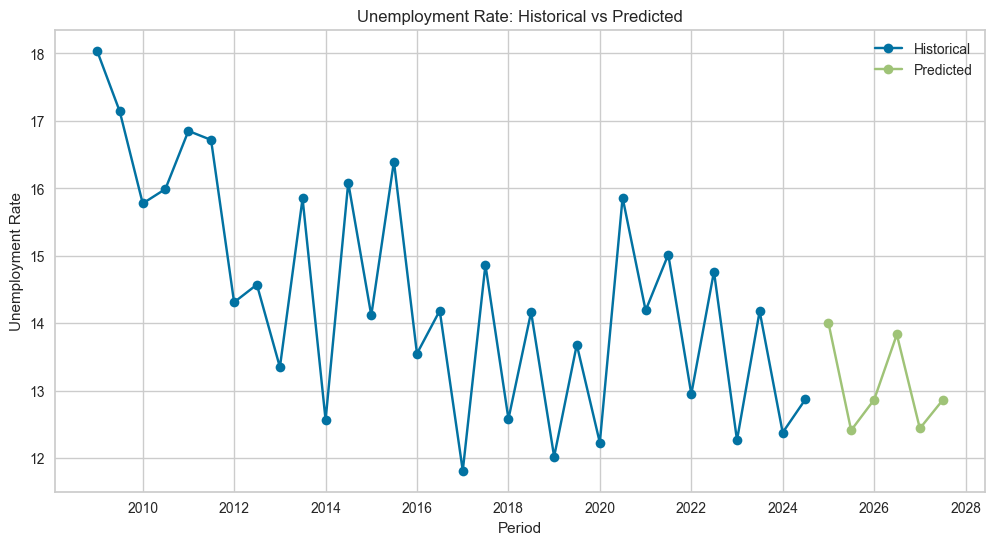

In [75]:
# Plotting
plt.figure(figsize=(12,6))

for t_type, group_data in combined_df.groupby('Type'):
    plt.plot(group_data.index.to_timestamp(), group_data['Unemployment_Rate'], 
             marker='o', label=t_type)

plt.title('Unemployment Rate: Historical vs Predicted')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()